### Importing the necessary modules and packages

In [1]:
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import torch
import random

/Users/somesh-19583/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the initial Dataset

In [2]:
df = pd.read_excel("/Users/somesh-19583/Desktop/My_Zoom/Dataset/train.xlsx")
df

,text,reason,label
0,this is an amazing app for online classes!but,good app for conducting online classes,1
1,very practical and easy to use,app is user-friendly,1
2,this app is very good for video conferencing.,good for video conferencing,1
3,i can not download this zoom app,unable to download zoom app,1
4,i am not able to download this app,want to download the app,1
...,...,...,...
2056,i am not getting jio tv properly.,unable to use with jio tv,1
2057,(learn from the netflix interface),netflix ui is better,1
2058,"hello,\ndisney+ must also be installed on chro...",unable to use disney on chromecast,1
2059,it is a shame that disney+ does not work on tv...,unable to use disney plus on tv,1


### Creating the rows for label '0' using Negative Class

In [4]:
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import random

# Load matched data (label = 1)
df_1 = pd.read_excel("/Users/somesh-19583/Desktop/My_Zoom/Dataset/train.xlsx")  # must have 'text', 'reason'

# Initialize sentence transformer
model = SentenceTransformer('all-MiniLM-L6-v2')

text_list = df_1['text'].tolist()
reason_list = df_1['reason'].tolist()

# Compute embeddings
text_embeddings = model.encode(text_list, convert_to_tensor=True)
reason_embeddings = model.encode(reason_list, convert_to_tensor=True)

# Generate mismatched text–reason negative samples
mismatched_data = []

for idx, text_emb in tqdm(enumerate(text_embeddings), total=len(text_embeddings)):
    text = text_list[idx]
    original_reason = reason_list[idx]
    
    similarities = util.cos_sim(text_emb, reason_embeddings)[0]
    dissimilar_indices = similarities.argsort(descending=False)

    for i in dissimilar_indices:
        i = i.item()
        sampled_reason = reason_list[i]
        if sampled_reason != original_reason and similarities[i] < 0.4:
            mismatched_data.append({
                'text': text,
                'reason': sampled_reason,
                'label': 0
            })
            break
    else:
        # Fallback if no sufficiently dissimilar found
        fallback_idx = random.choice([i for i in range(len(reason_list)) if i != idx])
        mismatched_data.append({
            'text': text,
            'reason': reason_list[fallback_idx],
            'label': 0
        })

# Word-swap: Shuffle middle words in reason
def word_swap(text):
    words = text.split()
    if len(words) > 2:
        middle = words[1:-1]
        random.shuffle(middle)
        return f"{words[0]} {' '.join(middle)} {words[-1]}"
    return text

swapped_negatives = []
for idx, row in df_1.iterrows():
    text = row['text']
    swapped_reason = word_swap(row['reason'])
    if swapped_reason != row['reason']:
        swapped_negatives.append({
            'text': text,
            'reason': swapped_reason,
            'label': 0
        })

# Combine negative examples
df_mismatch = pd.DataFrame(mismatched_data)
df_swap = pd.DataFrame(swapped_negatives)

df_0 = pd.concat([df_mismatch, df_swap], ignore_index=True)
df_0.drop_duplicates(subset=['text', 'reason'], inplace=True)

# Label positive data
df_1['label'] = 1

# Balance the dataset
min_len = min(len(df_1), len(df_0))
df_1_balanced = df_1.sample(min_len, random_state=42)
df_0_balanced = df_0.sample(min_len, random_state=42)

# Combine and shuffle
df_combined = pd.concat([df_1_balanced, df_0_balanced], ignore_index=True).sample(frac=1, random_state=42)

# Save to Excel
df_combined.to_excel("/Users/somesh-19583/Desktop/My_Zoom/Dataset/semantic_augmented_balanced_dataset.xlsx", index=False)

# Show a sample
df_combined.sample(5)


100%|██████████| 2061/2061 [00:06<00:00, 324.28it/s]


,text,reason,label
1293,this app keeps learning a little bit of splash...,app keeps getting splashed out,1
3092,online classes are very bad.,want to enable original sound,0
1305,updating app gone wrong.,updating app gone wrong,1
1475,on the smartphone there is no way to configure...,want to change settings,1
3107,i had not visited hulu for a while on my ipad.,unable on use hulu to ios,0


### Loading the complete Dataset

In [5]:
df = pd.read_excel("/Users/somesh-19583/Desktop/My_Zoom/Dataset/semantic_augmented_balanced_dataset.xlsx")
df.sample(5)

,text,reason,label
2276,"conferences crash every minute, sound does not...",sound to does a not when work connecting confe...,0
4045,but when the internet is a little slow it take...,internet is slow,1
3347,the appt shuts down twice,app shuts down twice,1
1383,really wish the mobile client allowed you to s...,want save to recordings locally,0
2033,no options exist to change subscriptions in th...,want to change subscriptions,1


### Data Preprocessing

In [6]:
import pandas as pd
from transformers import BertTokenizer
import re


# 1. Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 2. Basic Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)           # Remove punctuation
    text = re.sub(r"\s+", ' ', text).strip()             # Remove extra spaces
    return text

# 3. Apply cleaning
df["text_clean"] = df["text"].apply(clean_text)
df["reason_clean"] = df["reason"].apply(clean_text)

# 4. Tokenization
# You can choose return_tensors='pt' if using PyTorch downstream
encoded_inputs = tokenizer(
    list(df["text_clean"]),
    list(df["reason_clean"]),
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# Output tokens (input_ids, attention_mask, token_type_ids)
print(encoded_inputs.keys())
print("Input IDs shape:", encoded_inputs['input_ids'].shape)


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Input IDs shape: torch.Size([4122, 76])


In [7]:
df = df.drop(columns=['text','reason'])
df

,label,text_clean,reason_clean
0,1,i want to watch the games,want to watch the games
1,1,unable to connect audio over cellularwifi,want to connect to wifi
2,1,i hate this app becouse this app do not have b...,app does not have background filters
3,1,it does not let me relax during class,want to relax during class
4,1,it is the best app for chatting and meetings,app is good for meetings and chatting
...,...,...,...
4117,0,i have online classes and since a few days thi...,want attend online to lessons
4118,1,while watching highlights during ads it starts...,facing buffering issues while ads are playing
4119,0,online classes are very bad,want to enable original sound
4120,0,i forget my password and tried to set new pass...,want expression icons on app


### Model Development

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1 - Training loss: 0.2135
Epoch 1 - Validation Accuracy : 0.9624
Epoch 1 - Precision         : 0.9477
Epoch 1 - Recall         : 0.9779
Epoch 1 - F1-Score         : 0.9626


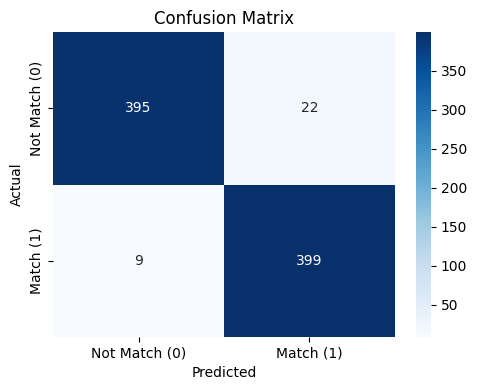


Epoch 2 - Training loss: 0.0879
Epoch 2 - Validation Accuracy : 0.9248
Epoch 2 - Precision         : 0.8681
Epoch 2 - Recall         : 1.0000
Epoch 2 - F1-Score         : 0.9294


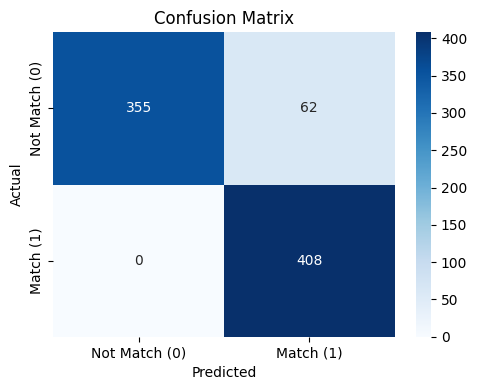


Epoch 3 - Training loss: 0.0513
Epoch 3 - Validation Accuracy : 0.9782
Epoch 3 - Precision         : 0.9643
Epoch 3 - Recall         : 0.9926
Epoch 3 - F1-Score         : 0.9783


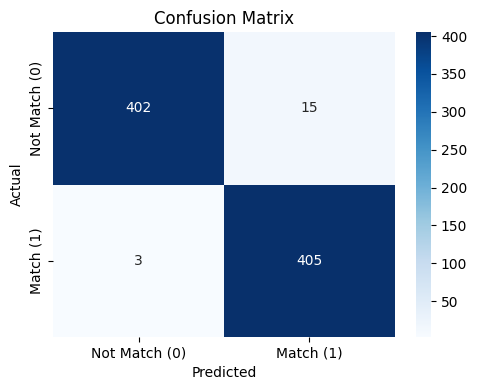

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Split
train_texts, val_texts, train_reasons, val_reasons, train_labels, val_labels = train_test_split(
    df['text_clean'], df['reason_clean'], df['label'], test_size=0.2, random_state=42
)

# 2. Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), list(train_reasons), truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(list(val_texts), list(val_reasons), truncation=True, padding=True, return_tensors='pt')

# 3. Dataset
class TextPairDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = TextPairDataset(train_encodings, train_labels)
val_dataset = TextPairDataset(val_encodings, val_labels)

# 4. Model + Optimizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=5e-5)

# 5. DataLoaders (Larger batch size to speed up)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 6. Train for 1 Epoch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(3):  # Reduce to 3 epoch for faster execution
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"\nEpoch {epoch+1} - Training loss: {total_loss / len(train_loader):.4f}")
    
    # 7. Evaluation + Confusion Matrix
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true.extend(batch['labels'].cpu().numpy())
    
    acc = accuracy_score(true, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true, preds, average='binary', pos_label=1)
    
    print(f"Epoch {epoch+1} - Validation Accuracy : {acc:.4f}")
    print(f"Epoch {epoch+1} - Precision         : {precision:.4f}")
    print(f"Epoch {epoch+1} - Recall         : {recall:.4f}")
    print(f"Epoch {epoch+1} - F1-Score         : {f1:.4f}")
    
    # 8. Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Match (0)", "Match (1)"], yticklabels=["Not Match (0)", "Match (1)"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [ ]:

model.save_pretrained("/Users/somesh-19583/Desktop/My_Zoom/my_model/feedback_model")
tokenizer.save_pretrained("/Users/somesh-19583/Desktop/My_Zoom/my_model/feedback_model")


('/Users/somesh-19583/Desktop/My_Zoom/my_model/feedback_model/tokenizer_config.json',
 '/Users/somesh-19583/Desktop/My_Zoom/my_model/feedback_model/special_tokens_map.json',
 '/Users/somesh-19583/Desktop/My_Zoom/my_model/feedback_model/vocab.txt',
 '/Users/somesh-19583/Desktop/My_Zoom/my_model/feedback_model/added_tokens.json')

In [ ]:
import gradio as gr
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained("/Users/somesh-19583/Desktop/My_Zoom/my_model/feedback_model")  # replace with your path
tokenizer = BertTokenizer.from_pretrained("/Users/somesh-19583/Desktop/My_Zoom/my_model/feedback_model")
model.eval()

# Define prediction function
def classify_feedback(text, reason):
    inputs = tokenizer(text, reason, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
    
    if prediction == 1:
        return "Feedback is Accepted ✅"
    else:
        return "❌ Please update it properly as the text and reason do not match up."

# Load reasons from evaluation Excel (if needed)
import pandas as pd
eval_df = pd.read_excel("/Users/somesh-19583/Desktop/My_Zoom/Dataset/evaluation.xlsx")  # replace with actual path
unique_reasons = eval_df['reason'].dropna().unique().tolist()

# Create Gradio UI
with gr.Blocks() as demo:
    gr.Image(value="https://i.postimg.cc/K8YRfG0q/Virtual-Meeting-Cartoon.png", label="Company Logo")
    gr.Markdown("## My Zoom: A Transformer-Based Model for Contextual Feedback Validation")
    with gr.Row():
        text_input = gr.Textbox(label="Share your Feedback")
        reason_input = gr.Dropdown(choices=unique_reasons, label="Select Reason")
    classify_button = gr.Button("Submit")
    output = gr.Textbox(label="Result")
    
    classify_button.click(fn=classify_feedback, inputs=[text_input, reason_input], outputs=output)

# Launch
demo.launch()


* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.
